<a href="https://colab.research.google.com/github/RajaniBoddupally/Assignment2-RM/blob/main/Code_RM_A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install necessary libraries
!pip install transformers -q
!pip install -U scikit-learn -q
!pip install wordcloud -q
# Import all required libraries for data processing, visualization, modeling, and evaluation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
from tqdm import tqdm
from wordcloud import WordCloud
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# Set the device to GPU if available, else fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 84.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.0 which is incompatible.
Using device: cuda


In [2]:
# Define the URL of the CSV file from the GitHub repository
Emotefile = 'https://raw.githubusercontent.com/RajaniBoddupally/Assignment2-RM/refs/heads/main/Emotion_classify_Data.csv'

# Read the CSV file from the specified URL into a DataFrame
Emotefile_Data = pd.read_csv(Emotefile)

# Print the first 5 rows of the DataFrame
print(Emotefile_Data.head())


                                             Comment Emotion
0  i seriously hate one subject to death but now ...    fear
1                 im so full of life i feel appalled   anger
2  i sit here to write i start to dig out my feel...    fear
3  ive been really angry with r and i feel like a...     joy
4  i feel suspicious if there is no one outside l...    fear


In [3]:
# Convert all column names in the DataFrame to lowercase
Emotefile_Data.columns = [col.lower() for col in Emotefile_Data.columns]

# Display basic information about the dataset
print('\n Dataset Info:\n')
print(Emotefile_Data.info())

# Show descriptive statistics for numerical columns
print('\n Descriptive Statistics:\n', Emotefile_Data.describe(), '\n\n')

# Check and print the number of duplicate rows in the dataset
print('\nNumber of Duplicated Rows:', Emotefile_Data.duplicated().sum(), '\n\n')



 Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5937 entries, 0 to 5936
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  5937 non-null   object
 1   emotion  5937 non-null   object
dtypes: object(2)
memory usage: 92.9+ KB
None

 Descriptive Statistics:
                                                   comment emotion
count                                                5937    5937
unique                                               5934       3
top     i feel pretty tortured because i work a job an...   anger
freq                                                    2    2000 



Number of Duplicated Rows: 0 




In [4]:
# Check for null (missing) values in each column
print("Null values in each column:\n")
print(Emotefile_Data.isnull().sum())

# Display rows with missing values if any are found
if Emotefile_Data.isnull().any().any():
    print("\nRows with null values:\n")
    display(Emotefile_Data[Emotefile_Data.isnull().any(axis=1)])
else:
    print("\n✅ No missing values found in the dataset.")


Null values in each column:

comment    0
emotion    0
dtype: int64

✅ No missing values found in the dataset.


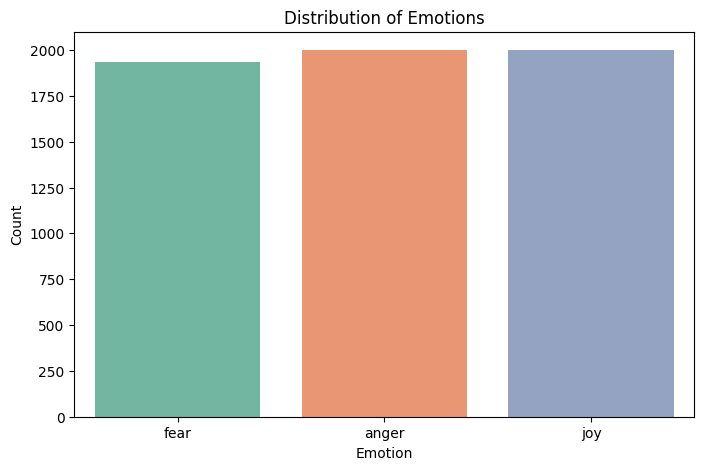

In [5]:
# Plot the distribution of emotion labels without future warning
plt.figure(figsize=(8, 5))
sns.countplot(data=Emotefile_Data, x='emotion', hue='emotion', palette='Set2', legend=False)
plt.title('Distribution of Emotions')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()

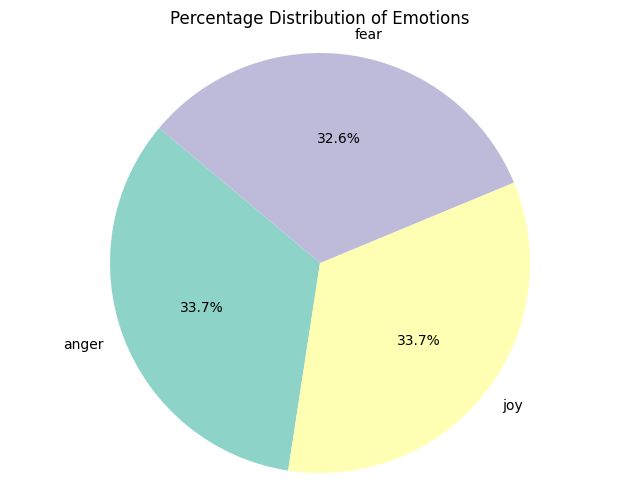

In [6]:
# Calculate the count of each emotion category
emotion_counts = Emotefile_Data['emotion'].value_counts()
emotion_labels = emotion_counts.index
emotion_sizes = emotion_counts.values

# Create a pie chart to show the percentage distribution of emotions
plt.figure(figsize=(8, 6))
plt.pie(emotion_sizes,
        labels=emotion_labels,
        autopct='%1.1f%%',
        startangle=140,
        colors=plt.cm.Set3.colors)

# Set title and making sure that the pie is a perfect circle
plt.title('Percentage Distribution of Emotions')
plt.axis('equal')
plt.show()


In [7]:
# Convert the 'emotion' column to categorical type and encode it as numeric labels
Emotefile_Data['emotion'] = Emotefile_Data['emotion'].astype('category')
Emotefile_Data['label'] = Emotefile_Data['emotion'].cat.codes

# Extract the list of original emotion categories in order of their assigned codes
Emo_Lable_nms = Emotefile_Data['emotion'].cat.categories.tolist()

# Display the mapping between numeric labels and emotion categories
print("Label mapping:", dict(enumerate(Emo_Lable_nms)))


Label mapping: {0: 'anger', 1: 'fear', 2: 'joy'}



Text Length Stats:
 count    5937.000000
mean       97.425973
std        56.196202
min         9.000000
25%        54.000000
50%        86.000000
75%       130.000000
max       298.000000
Name: EM_Comment_Len, dtype: float64


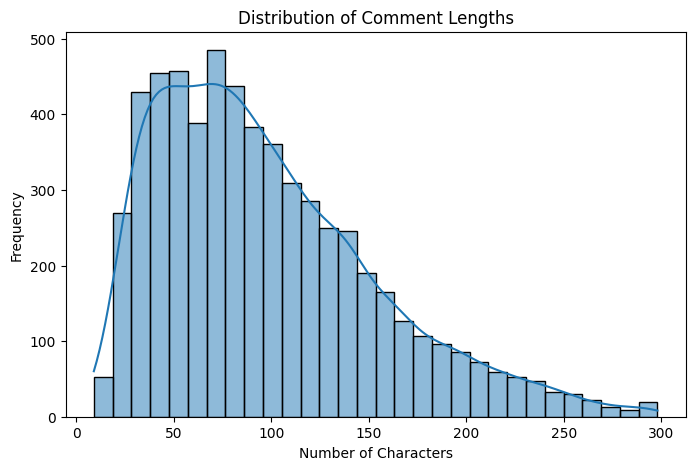

In [8]:
# Add a new column that stores the length of each comment
Emotefile_Data['EM_Comment_Len'] = Emotefile_Data['comment'].apply(len)

# Display summary statistics of the comment lengths
print("\nText Length Stats:\n", Emotefile_Data['EM_Comment_Len'].describe())

# Plot a histogram showing the distribution of comment lengths
plt.figure(figsize=(8, 5))
sns.histplot(Emotefile_Data['EM_Comment_Len'], bins=30, kde=True)
plt.title("Distribution of Comment Lengths")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.show()

/tmp/ipython-input-9-4201947701.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=Emotefile_Data, x='emotion', y='EM_Comment_Len', palette='Pastel2')


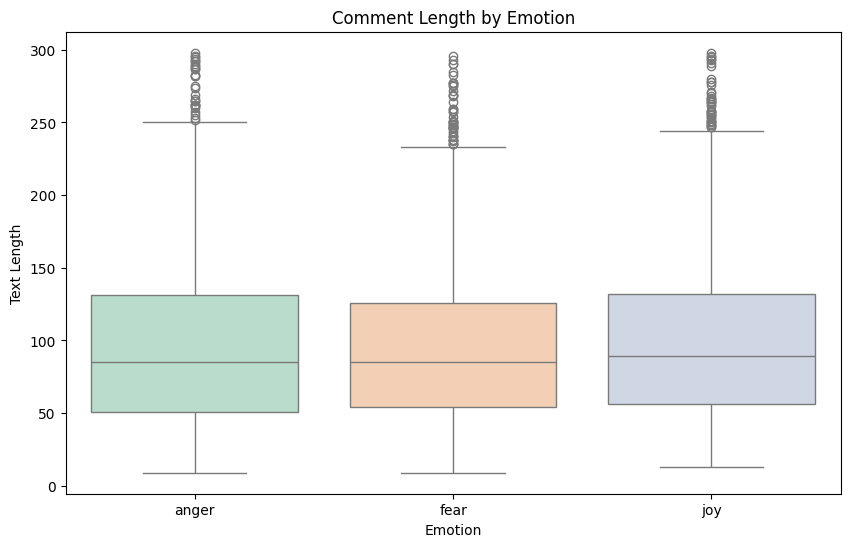

In [9]:
# Create a boxplot to compare comment lengths across different emotion categories
plt.figure(figsize=(10, 6))
sns.boxplot(data=Emotefile_Data, x='emotion', y='EM_Comment_Len', palette='Pastel2')
plt.title("Comment Length by Emotion")
plt.xlabel("Emotion")
plt.ylabel("Text Length")
plt.show()


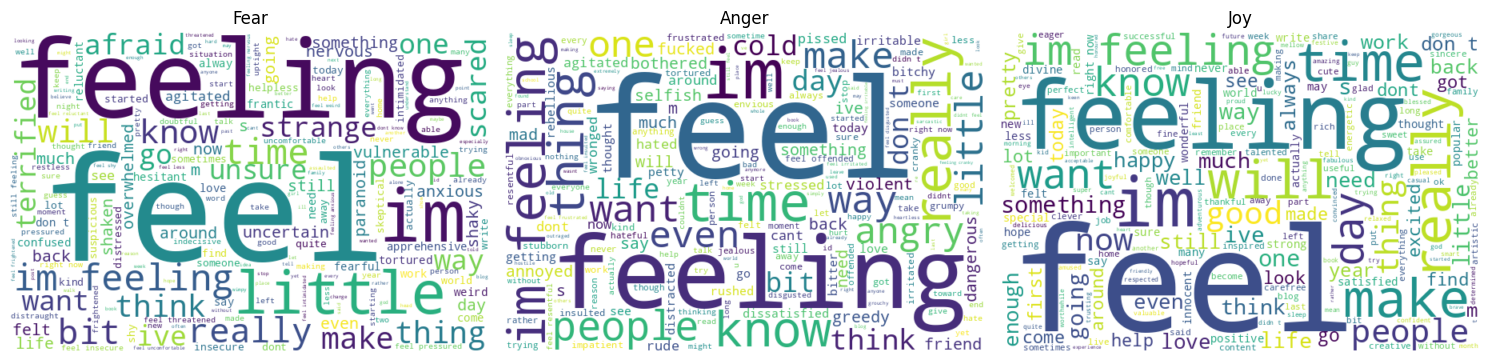

In [10]:
# Generate word clouds for each unique emotion category
emotions = Emotefile_Data['emotion'].unique()
plt.figure(figsize=(15, 8))

for i, emotion in enumerate(emotions):
    # Combine all comments for the current emotion into a single string
    text = " ".join(Emotefile_Data[Emotefile_Data['emotion'] == emotion]['comment'])

    # Generate a word cloud from the combined text
    wordcloud = WordCloud(width=600, height=400, background_color='white', colormap='viridis').generate(text)

    # Plot the word cloud
    plt.subplot(1, len(emotions), i + 1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"{emotion.capitalize()}")

# Adjust layout and display all word clouds
plt.tight_layout()
plt.show()


In [11]:
nltk.download('stopwords')
nltk.download('wordnet')
# Initialize the WordNet lemmatizer and define English stopwords
lem_emo_data = WordNetLemmatizer()
Emo_Stop_Words = set(stopwords.words('english'))

# Define a function to clean and preprocess emotion comment text
def Emote_Change_PP(Emo_Comment):
    """
    Clean and preprocess a given emotion comment.

    This function performs the following steps:
    1. Converts text to lowercase
    2. Removes punctuation and numeric characters
    3. Splits the text into tokens (words)
    4. Removes English stopwords
    5. Applies lemmatization to each word

    Parameters:
    text (str): The raw comment text to be cleaned

    Returns:
    str: The cleaned and lemmatized text
    """
    Emo_lower = Emo_Comment.lower()
    Emo_Clean = re.sub(r'[^a-z\s]', '', Emo_lower)
    Emo_Token = Emo_Clean.split()
    Emo_lem_token = [lem_emo_data.lemmatize(word) for word in Emo_Token if word not in Emo_Stop_Words]
    return ' '.join(Emo_lem_token)


# Apply the preprocessing function to the 'comment' column
Emotefile_Data['Emote_cleaned'] = Emotefile_Data['comment'].apply(Emote_Change_PP)
# Display original and cleaned comment text for comparison
Emotefile_Data[['comment', 'Emote_cleaned']].head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


,comment,Emote_cleaned
0,i seriously hate one subject to death but now ...,seriously hate one subject death feel reluctan...
1,im so full of life i feel appalled,im full life feel appalled
2,i sit here to write i start to dig out my feel...,sit write start dig feeling think afraid accep...
3,ive been really angry with r and i feel like a...,ive really angry r feel like idiot trusting fi...
4,i feel suspicious if there is no one outside l...,feel suspicious one outside like rapture happe...


In [12]:
# Display the first 5 rows of the dataset
Emotefile_Data.head()


,comment,emotion,label,EM_Comment_Len,Emote_cleaned
0,i seriously hate one subject to death but now ...,fear,1,73,seriously hate one subject death feel reluctan...
1,im so full of life i feel appalled,anger,0,34,im full life feel appalled
2,i sit here to write i start to dig out my feel...,fear,1,131,sit write start dig feeling think afraid accep...
3,ive been really angry with r and i feel like a...,joy,2,89,ive really angry r feel like idiot trusting fi...
4,i feel suspicious if there is no one outside l...,fear,1,87,feel suspicious one outside like rapture happe...


In [13]:
# Split the dataset into training and testing sets (80/20 split) with stratified sampling
Emo_Comment_Train, Emo_Comment_Test, Emo_Lbl_Train, Emo_Lbl_Test = train_test_split(
    Emotefile_Data['Emote_cleaned'],
    Emotefile_Data['label'],
    test_size=0.2,
    random_state=123456,
    stratify=Emotefile_Data['label']
)

# Convert target label variables to categorical type
Emo_Lbl_Train = Emo_Lbl_Train.astype('category')
Emo_Lbl_Test = Emo_Lbl_Test.astype('category')


In [14]:
# Load the pre-trained BERT tokenizer
Emo_tokenize = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize and encode the training and testing comment text
Emo_encode_Train = Emo_tokenize(Emo_Comment_Train.tolist(), truncation=True, padding=True, return_tensors='pt')
Emo_encode_Test = Emo_tokenize(Emo_Comment_Test.tolist(), truncation=True, padding=True, return_tensors='pt')

# Convert training and testing labels to PyTorch tensors
Emo_Trn_lbls = torch.tensor(Emo_Lbl_Train.cat.codes.values)
Emo_Test_lbls = torch.tensor(Emo_Lbl_Test.cat.codes.values)

# Create TensorDatasets for training and testing
Emo_Train_DS = TensorDataset(Emo_encode_Train['input_ids'], Emo_encode_Train['attention_mask'], Emo_Trn_lbls)
Emo_Test_DS = TensorDataset(Emo_encode_Test['input_ids'], Emo_encode_Test['attention_mask'], Emo_Test_lbls)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [15]:
# Load the pre-trained BERT model for sequence classification
Emo_Model_Bert = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=len(Emo_Lable_nms)
).to(device)

# Define the optimizer using AdamW
Emo_Optz = AdamW(Emo_Model_Bert.parameters(), lr=1e-5)

# Define the loss function for multi-class classification
Emo_Loss_Fn = nn.CrossEntropyLoss()


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
# Create DataLoaders for training and testing
Emo_Train_Ldr = DataLoader(Emo_Train_DS, batch_size=8, shuffle=True)
Emo_Test_Ldr = DataLoader(Emo_Test_DS, batch_size=8)

# Initialize lists to store accuracy and loss values across epochs
Emo_Train_Acc = []
Emo_Test_Acc = []
Emo_epoch_loss = []

# Loop through multiple training epochs
for epoch in range(5):  # Adjust the number of epochs as needed
    Emo_Model_Bert.train()  # Set model to training mode
    Ep_total_loss = 0
    Emo_Lbl_crct = 0
    Emo_all_ttl = 0

    # Iterate through training batches
    for batch in tqdm(Emo_Train_Ldr, desc=f"Epoch {epoch+1} - Training"):
        Emo_Ip_Ids, Emo_At_Masks, Emo_ep_lbls = [b.to(device) for b in batch]
        Emo_ep_lbls = Emo_ep_lbls.long()

        # Forward pass and loss computation
        Emo_Optz.zero_grad()
        Emo_ops = Emo_Model_Bert(input_ids=Emo_Ip_Ids, attention_mask=Emo_At_Masks)
        Emo_ep_loss = Emo_Loss_Fn(Emo_ops.logits, Emo_ep_lbls)

        # Backward pass and optimization
        Emo_ep_loss.backward()
        Emo_Optz.step()

        # Accumulate loss and correct predictions
        Ep_total_loss += Emo_ep_loss.item()
        Emo_bert_pred = torch.argmax(Emo_ops.logits, dim=1)
        Emo_Lbl_crct += (Emo_bert_pred == Emo_ep_lbls).sum().item()
        Emo_all_ttl += Emo_ep_lbls.size(0)

    # Calculate and store training accuracy and loss for this epoch
    Eval_Trn_acc = Emo_Lbl_crct / Emo_all_ttl
    Emo_Train_Acc.append(Eval_Trn_acc)
    Emo_epoch_loss.append(Ep_total_loss / len(Emo_Train_Ldr))

    # Set model to evaluation mode
    Emo_Model_Bert.eval()
    Emo_Test_Crct = 0
    Emo_Eval_ttl = 0

    # Evaluate model on test data without updating gradients
    with torch.no_grad():
        for batch in Emo_Test_Ldr:
            Eval_ips, Eval_att_masks, Eval_lbls = [b.to(device) for b in batch]
            Eval_lbls = Eval_lbls.long()
            totch_op = Emo_Model_Bert(input_ids=Eval_ips, attention_mask=Eval_att_masks)
            Eval_preds = torch.argmax(totch_op.logits, dim=1)
            Emo_Test_Crct += (Eval_preds == Eval_lbls).sum().item()
            Emo_Eval_ttl += Eval_lbls.size(0)

    # Calculate and store test accuracy for this epoch
    Eval_Test_acc = Emo_Test_Crct / Emo_Eval_ttl
    Emo_Test_Acc.append(Eval_Test_acc)

    # Display training and test accuracy along with average training loss
    print(f"Epoch {epoch+1}: Training Accuracy = {Eval_Trn_acc:.4f} \n , Testing Accuracy = {Eval_Test_acc:.4f}, Loss = {Ep_total_loss / len(Emo_Train_Ldr):.4f}")


Epoch 1 - Training: 100%|██████████| 594/594 [01:14<00:00,  7.96it/s]


Epoch 1: Training Accuracy = 0.9695 
 , Testing Accuracy = 0.9646, Loss = 0.0954


Epoch 2 - Training: 100%|██████████| 594/594 [01:14<00:00,  8.00it/s]


Epoch 2: Training Accuracy = 0.9823 
 , Testing Accuracy = 0.9537, Loss = 0.0470


Epoch 3 - Training: 100%|██████████| 594/594 [01:14<00:00,  8.03it/s]


Epoch 3: Training Accuracy = 0.9853 
 , Testing Accuracy = 0.9689, Loss = 0.0411


Epoch 4 - Training: 100%|██████████| 594/594 [01:14<00:00,  8.03it/s]


Epoch 4: Training Accuracy = 0.9878 
 , Testing Accuracy = 0.9672, Loss = 0.0303


Epoch 5 - Training: 100%|██████████| 594/594 [01:14<00:00,  8.02it/s]


Epoch 5: Training Accuracy = 0.9933 
 , Testing Accuracy = 0.9621, Loss = 0.0204


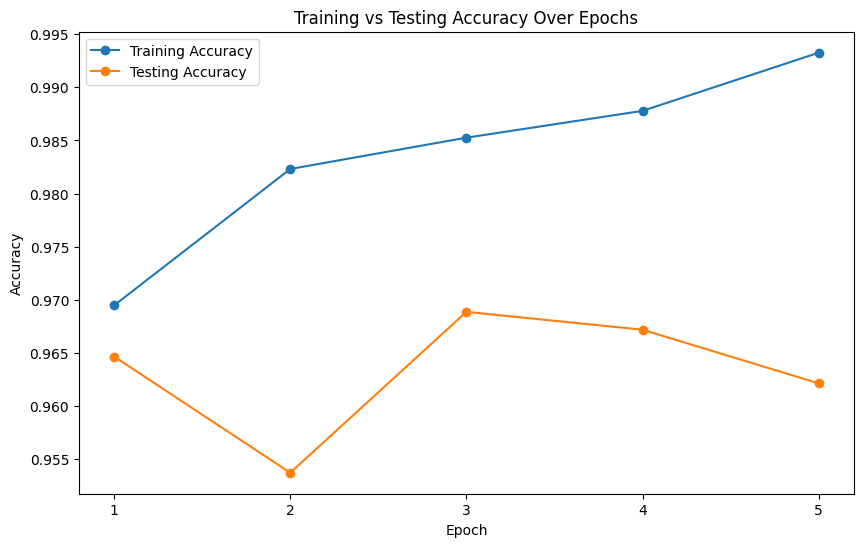

In [18]:
# Plot training and testing accuracy over epochs
Num_epochs = list(range(1, len(Emo_Train_Acc) + 1))
plt.figure(figsize=(10, 6))
plt.plot(Num_epochs, Emo_Train_Acc, marker='o', label='Training Accuracy')
plt.plot(Num_epochs, Emo_Test_Acc, marker='o', label='Testing Accuracy')
plt.title("Training vs Testing Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks(Num_epochs)
plt.legend()
plt.show()


In [21]:
# Set the model to evaluation mode
Emo_Model_Bert.eval()

# Create a DataLoader for the test dataset
Emo_Test_Ldr = DataLoader(Emo_Test_DS, batch_size=8)

# Initialize lists to store predictions and true labels
Emo_Berts_Preds, Emo_org_lbls = [], []

# Perform inference on test data without computing gradients
with torch.no_grad():
    for batch in Emo_Test_Ldr:
        Emo_test_ips, Emo_test_Att, EMo_test_lbls = [b.to(device) for b in batch]
        Emo_test_op = Emo_Model_Bert(input_ids=Emo_test_ips, attention_mask=Emo_test_Att)
        Emo_test_pred = torch.argmax(Emo_test_op.logits, dim=1)
        Emo_Berts_Preds.extend(Emo_test_pred.cpu().numpy())
        Emo_org_lbls.extend(EMo_test_lbls.cpu().numpy())

# Compute and display evaluation metrics
EVal_Test_acc_all = accuracy_score(Emo_org_lbls, Emo_Berts_Preds)
print(f"Test Accuracy on Unseen Emotion Data: {EVal_Test_acc_all:.2f}")
print("\nClassification Report on Unseen Emotion Data:\n", classification_report(Emo_org_lbls, Emo_Berts_Preds, target_names=Emo_Lable_nms))


Test Accuracy on Unseen Emotion Data: 0.96

Classification Report on Unseen Emotion Data:
               precision    recall  f1-score   support

       anger       0.95      0.96      0.95       400
        fear       0.95      0.95      0.95       388
         joy       0.99      0.97      0.98       400

    accuracy                           0.96      1188
   macro avg       0.96      0.96      0.96      1188
weighted avg       0.96      0.96      0.96      1188



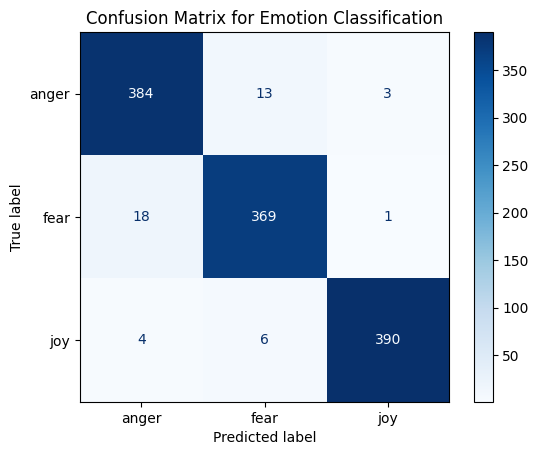

In [26]:
# Plot the confusion matrix for the test predictions
Emo_Eval_Confmat = confusion_matrix(Emo_org_lbls, Emo_Berts_Preds)
EMo_Cm_Disp = ConfusionMatrixDisplay(confusion_matrix=Emo_Eval_Confmat, display_labels=Emo_Lable_nms)
EMo_Cm_Disp.plot(cmap = 'Blues')
plt.title("Confusion Matrix for Emotion Classification")
plt.show()

In [25]:
# Compare predicted and actual emotion labels for 5 random test samples
Emo_Test_Samples = np.random.choice(len(Emo_Comment_Test), 5, replace=False)

for Ets in Emo_Test_Samples:
    Test_Sample_Emo = Emo_Comment_Test.iloc[Ets]
    Emo_orgl_Label = Emo_Lable_nms[Emo_Lbl_Test.iloc[Ets]]

    # Tokenize the sample and send it to the model
    Ips_token = Emo_tokenize(Test_Sample_Emo, return_tensors='pt', truncation=True, padding=True).to(device)
    with torch.no_grad():
        Emo_Op_TOken = Emo_Model_Bert(**Ips_token)
    Emo_Pred_Samp_Label = Emo_Lable_nms[torch.argmax(Emo_Op_TOken.logits, dim=1).item()]

    # Display text, actual label, and predicted label
    print("\n Sample Comment from Test Dataset:", Test_Sample_Emo)
    print("Actual Emotion   :", Emo_orgl_Label)
    print("Predicted Emotion:", Emo_Pred_Samp_Label)



 Sample Comment from Test Dataset: feel fabulous birding weekend everyone
Actual Emotion   : joy
Predicted Emotion: joy

 Sample Comment from Test Dataset: answer feeling clever
Actual Emotion   : joy
Predicted Emotion: joy

 Sample Comment from Test Dataset: feel student classroom hostile towards display intellect like rest society
Actual Emotion   : anger
Predicted Emotion: anger

 Sample Comment from Test Dataset: find hard feel jolly throng people around lost fervor getting stuff cant see heart green wallet encouraged constant barrage pressure every angle shop buy
Actual Emotion   : joy
Predicted Emotion: joy

 Sample Comment from Test Dataset: im feeling outfit heel gorgeous
Actual Emotion   : joy
Predicted Emotion: joy
